In [22]:
import csv, re, nltk, string
from nltk.stem import PorterStemmer
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import gensim
from pprint import pprint
from nltk.stem.porter import *
from gensim.models import CoherenceModel

import pyLDAvis.gensim

import warnings
warnings.simplefilter(action='ignore', category=Warning)



In [23]:
pd.set_option('display.max_columns', 500)

Stagioni a disposizione: prima decima e diciannovesima

In [24]:
use_season = 19

In [25]:
path = 'C:/Users/david/Desktop/TEXT DATA MINING/Progetto/season {}.csv'.format(str(use_season))

seas1 = []

id_count = 0

## pre-processing, data cleaning

In [26]:
# !!! clean data
def process_string(string_in):
    new_text= string_in.lower()   #testo minuscolo
    new_text = re.sub(r'\d+', '', new_text) #rimozione numeri
    new_text = re.sub(r'^\s', '', new_text) # rimozione spazio
    new_text = re.sub(r'\s$', '', new_text) # rimozione spazio
    new_text = re.sub(r'\s\s', ' ', new_text) #rimozione spazi extra
    new_text = new_text.translate(str.maketrans('', '', string.punctuation))  # (str.maketrans('', '', string.punctuation)) rimozione punteggiatura
    new_text = re.sub(r'\s\s', ' ', new_text) #nuovamente rimozione spazi extra
    new_text = re.sub(r'^\s', '', new_text) # rimozione spazio

    return new_text

def process_row(string_in):
    if '\r\n{},'.format(str(use_season)) in string_in[0]:
        out = [id_count]
        ctr = 0
        temp = ''
        cursor = string_in[0].split(',')
        for elem in cursor:
            if ctr < 3:
                out.append(elem)
                ctr += 1
            else:
                temp += elem+''
        out.append(process_string(temp))
        return out
    else:
        return None
    
with open(path, newline='') as csvfile:
    file = csv.reader(csvfile, delimiter='\n')
    for row in file:
        proc_row = process_row(row)
        if proc_row:
            seas1.append(proc_row)
            id_count += 1
            
def get_authors():
    return list(set([x[3] for x in seas1]))

## descriptive statistics

In [27]:
# !!! statistica descrittiva
    
def get_descr_stat(data, plot=False):
    
    '''
    # battute x personaggio
    # parole x battuta
    '''
    
    out = [(x[3], len(x[-2]), 1) for x in data]
    
    df = pd.DataFrame(out, columns=['character', 'words_count', 'ctr'])
    
    g1 = df.groupby('character')['words_count'].agg({'Somma parole/battuta':'sum', 'Media parole/battuta':'mean'})
    g2 = df.groupby('character')['ctr'].sum()
    g2 = pd.DataFrame(g2.values, index=g2.index, columns=['Conta battute'])
    
    j = pd.merge(g1, g2, left_index=True, right_index=True).sort_values('Conta battute', ascending=False).head(10)
    
    c = g2.sum().values[0]
    j['Pct di battute su totale'] = j['Conta battute'].apply(lambda x: 100*np.round(x / c, 3))
    
    print('\nNumero di personaggi per stagione:      {}'.format(g2.shape[0]))
    print('Numero di battute in tutta la stagione: {}'.format(c))
    
    print('\nStatistica descrittiva per i primi 10 personaggi con più battute:')
    print(j)
    print('\n')
    
    def viz():
        c = list(j.index)[::-1]
        f = j['Conta battute'].tolist()[::-1]
        plt.title('Numero di battute dei primi 10 personaggi')
        plt.barh(c, f, color=['red', 'blue', 'purple', 'green', 'orange'])
        plt.show()
       
    if plot:
        viz()
        
    return j
    

## tokenization

In [28]:
# !!! tokenization
def tokenize(tot):

    length = len(tot)
    for n in range(length):
        splitted = tot[n][-1].split(' ')
        tot[n].append(splitted)
    return tot

## remove stop words

In [29]:
# !!! remove stop words
def remove_stop_words(tot):
    stop_words = nltk.corpus.stopwords.words('english')
    stop_words += ['im', 'youre', 'thats', 'get', 'cant', 'dont', 'go', 
                   'going', 'gonna', 'like', 'got', 'come', 'look',
                   'see', 'theres', 'say', 'want', 'wanna', 'make', 'yes',
                   'right', '']
    length = len(tot)
    for n in range(length):
        chunk = []
        for word in tot[n][-1]:
            if word not in stop_words:
                chunk.append(word)
        tot[n].append(chunk)
    return tot


## stemming

In [30]:
# !!! stemming
def stemming(x):
    out = []
    porter = PorterStemmer()
    for word in x:
        stemmed = porter.stem(word)
        out.append(stemmed)
    return out

def cycle_stemming(tot):
    n = len(tot)
    for i in range(n):
        stemmed = stemming(tot[i][-1])
        tot[i].append(stemmed)
    return tot


## POS

In [31]:
# !!! POS    
def analizza_frase(frase):
    import stanfordnlp
    base = 'C:\\Users\\david\\Downloads\\en_ewt_models\\'
    config = {
    'processors': 'tokenize,pos,lemma,depparse', # Comma-separated list of processors to use
    'lang': 'en', # Language code for the language to build the Pipeline in
    'model_path': base + 'en_ewt_tokenizer.pt', 
    'pos_model_path': base + 'en_ewt_tagger.pt', 
    'pos_pretrain_path': base + 'en_ewt.pretrain.pt', 
    'lemma_model_path': base + 'en_ewt_lemmatizer.pt', 
    'depparse_model_path': base + 'en_ewt_parser.pt', 
    'depparse_pretrain_path': base + 'en_ewt.pretrain.pt', 
    'tokenize_pretokenized': False # Use pretokenized text as input and disable tokenization
    }
    nlp = stanfordnlp.Pipeline(**config)
    doc = nlp(frase)
    all_information_tab_separated = doc.conll_file.conll_as_string()
    print(all_information_tab_separated)
    return all_information_tab_separated

def pos_analyze(n):
    return analizza_frase(out[n][-3])

## n-grams

In [32]:
# !!! BIGRAMS 
# merge all
def calc_ngram_total(tot, n):
    corpus = []
    for row in tot:
        corpus += row[-1]
    out = pd.Series(nltk.ngrams(corpus, n)).value_counts()
    df = pd.DataFrame({'ngrams':out.index, 'counts':out.values})
    return df
    
# by author
def calc_ngrams_by_author(tot, n, author):
    corpus = []
    for row in tot:
        if row[3] == author:
            corpus += row[-1]
    out = pd.Series(nltk.ngrams(corpus, n)).value_counts()
    df = pd.DataFrame({'ngrams':out.index, 'counts':out.values})
    return df

# visualize
def visualize_bigrams(tot):
    
    bigrams = calc_ngram_total(tot, 2).iloc[:20]
    dict_grams = bigrams.set_index('ngrams').T.to_dict('records')
    G = nx.Graph()
    for bigrams, counts in dict_grams[0].items():
        G.add_edge(bigrams[0], bigrams[1], weight=(counts * 5))
    
    fig, ax = plt.subplots(figsize=(10, 8))
    pos = nx.spring_layout(G, k=2)
    nx.draw_networkx(G, pos,
                     font_size=12,
                     width=6,
                     edge_color='grey',
                     node_color='white',
                     with_labels = False,
                     ax=ax)
    # Create offset labels
    for key, value in pos.items():
        #x, y = value[0]+.135, value[1]+.045
        x, y = value[0], value[1]
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='blue', alpha=0.1),
                horizontalalignment='center', fontsize=10)
        
    plt.show()
    
    

## TF-IDF

In [33]:
# !!! TF_IDF
def get_most_important_chars(tot, n):
    auth_dict = {}
    for row in tot:
        if row[3] in auth_dict:
            auth_dict[row[3]] += 1
        else:
            auth_dict[row[3]] = 1
    out = sorted(auth_dict.items(), key=lambda x: x[1], reverse=True)[:n]
    return [x[0] for x in out]

def get_corpus_by_char(tot, char):
    corpus = []
    for row in tot:
        if row[3] == char:
            corpus += row[-1]
    return corpus

def get_db_by_episode(tot, n):
    out = []
    for row in tot:
        if str(n) == row[2]:
            out.append(row)
    return out

def get_text_of_episode(tot, n):
    out = ''
    for row in tot:
        if str(n) == row[2]:
            out += row[-3] + ' '
    return out

def get_text_of_season(tot):
    out = ''
    for row in tot:
        out += row[4] + ' '
    return out

def get_season_as_tokens(tot):
    out = []
    for row in tot:
        out += row[-1]
    return out

def count_words_in_season(tot):
    tokens = get_season_as_tokens(tot)
    count = {}
    for w in tokens:
        if w in count:
            count[w] += 1
        else:
            count[w] = 1
    return count
    
def get_corpus_by_episode(tot, n):
    corpus = []
    for row in tot:
        if str(n) == row[2]:
            corpus += row[-1]
    return corpus

def get_season_by_episode_as_text(tot):
    out = []
    n = max([int(x[2]) for x in tot])
    for epi in range(n):
        out.append(get_text_of_episode(tot, epi+1))
    return out

def get_bag_of_words_by_char(tot, n, char, plot=False):
    out = {c:[] for c in char}
    assert len(out) == 9, 'Devono necessariamente esserci 9 personaggi'
    for c in char:
        corpus = get_corpus_by_char(tot, c)
        bow = {}
        for w in corpus:
            if w in bow:
                bow[w] += 1
            else:
                bow[w] = 1
        out[c] = sorted(bow.items(), key=lambda x: x[1], reverse=True)[:n]
        
    # plots 
    if plot:
        ctr = 1
        for ch in char:
            w = [x[0] for x in out[ch]][::-1] 
            c = [x[1] for x in out[ch]][::-1]
            
            plt.subplot(3,3,ctr)
            plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.4)
            plt.title(ch)
            plt.barh(w, c, color=['red', 'blue', 'purple', 'green', 'orange'])        
            ctr += 1
            
        plt.show()
    return pd.DataFrame(out)
    
    
def get_bag_of_words(tot, n):
    corpus = []
    for row in tot:
        corpus += row[-1]
    count_words = {}
    for w in corpus:
        if w in count_words:
            count_words[w] += 1
        else:
            count_words[w] = 1
    out = sorted(count_words.items(), key=lambda x: x[1], reverse=True)[:n]
    return out
    
def get_word_matrix(tot, n, char_list):
    bag = [x[0] for x in get_bag_of_words(tot, n)]
    dict_bag = {char:{x:0 for x in bag} for char in char_list}
    for char in char_list:
        char_corpus = get_corpus_by_char(tot, char)    
        for w in char_corpus:
            if w in bag:
                dict_bag[char][w] += 1
    return dict_bag
        
def calculate_term_frequency(tot, n, char_list):
    word_matrix = get_word_matrix(tot, n, char_list)
    tf_dict = {char:{word:0 for word in word_matrix[char]} for char in word_matrix}
    for char in char_list:
        for word in word_matrix[char]:
            corpus = get_corpus_by_char(tot, char)
            length_corpus = len(corpus)
            count = sum([1 for x in corpus if x == word])
            tf_dict[char][word] = count / length_corpus
    return tf_dict

def calculate_idf(term_freq):
    term = list(term_freq.keys())[0]
    idf_dict = {word:0 for word in term_freq[term]}
    n_docs = len(idf_dict)
    for word in term_freq[term]:
        ctr = 0
        for char in term_freq:
            if term_freq[char][word] != 0:
                ctr += 1 
        idf_dict[word] = np.log(n_docs / ctr) 
    return idf_dict

def calculate_tf_idf(tot, n, char_list):
    
    tf = calculate_term_frequency(tot, n, char_list)
    idf = calculate_idf(tf)
    tf_idf = {char:{word:0 for word in tf[char]} for char in tf}
    for char in tf:
        for word in tf[char]:        
            tf_idf[char][word] = tf[char][word] * idf[word]

    return pd.DataFrame(tf_idf)

def visualize_tf_idf(tf_idf):
    tf_idf.plot(kind="bar")

## LDA

In [34]:
# !!! LDA
class LDA:
    def __init__(self, tot):
        self.data = get_season_by_episode_as_text(tot)
        self.wordnet_lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer()
        self.stopwords = nltk.corpus.stopwords.words('english')
        self.n_episodes = len(self.data)
   
    def transform(self):
        
        self.new_data = []
        for epi in self.data:
            tokens = nltk.tokenize.word_tokenize(epi)
            tokens = [t for t in tokens if t.isalpha()]
            tokens = [self.wordnet_lemmatizer.lemmatize(t) for t in tokens]
            tokens = [self.stemmer.stem(t) for t in tokens]
            tokens = [t for t in tokens if len(t) > 2]
            tokens = [t for t in tokens if t not in self.stopwords]
            self.new_data.append(tokens)
        
        return self.new_data
    
    def run_model(self):
        
        data = self.transform()
        dictionary = gensim.corpora.Dictionary(data)
        dictionary.filter_extremes(no_below=0, no_above=0.5, keep_n= 10000) #0   #0,5   #10000
        bow_corpus = [dictionary.doc2bow(doc) for doc in data]
        self.lda_model = gensim.models.LdaModel(bow_corpus, id2word=dictionary,
                                                num_topics=self.n_episodes, offset=2, #num_topics= numero che vogliamo / self.n_episodes
                                                random_state=100, update_every=1,
                                                passes=self.n_episodes, alpha='auto',  #passes= numero che vogliamo
                                                eta='auto', per_word_topics=True)
    
        pprint(self.lda_model.print_topics())
        print('\nPerplexity: ', self.lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

        # Compute Coherence Score
        coherence_model_lda = CoherenceModel(model=self.lda_model, texts=data, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print('\nCoherence Score: ', coherence_lda)
        pyLDAvis.enable_notebook()
        self.vis = pyLDAvis.gensim.prepare(self.lda_model, bow_corpus, dictionary)
        
        coherence_lda = coherence_model_lda.get_coherence()
        print('\nCoherence Score: ', coherence_lda)
        
        
        

            

In [35]:
def get_text_by_char(tot, char_list):    
    for char in char_list:
        corpus = get_corpus_by_char(tot, char)
        out = ''
        for t in corpus:
            out += t + ','
        out = out[:-1]
        
        name = char + '.txt'
        with open(name, 'x') as file:
            file.write(out)

# sentiment analysis

In [36]:
# !!! sentiment analysis
    
class Make_Sentiment:
    
    def __init__(self, data):
        from afinn import Afinn
        self.data = data
        self.n_episodes = int(max([int(x[2]) for x in self.data]))
        self.model = Afinn()
        
    def run(self):
        out = []
        
        def filter_by_points(x, minus, maxim):
            if (x < minus) or (x > maxim):
                return True
            else:
                return False
        
        for n in range(self.n_episodes):
            epi_corpus = get_corpus_by_episode(self.data, n+1)
            length = len(epi_corpus)
            points = sum([self.model.score(x) for x in epi_corpus if filter_by_points(self.model.score(x), -1, 1)]) / length
            out.append([n+1, points])
        
        e = [x[0] for x in out]
        v = [x[1] for x in out]
        
        m = sum(v) / self.n_episodes
        plt.title('Sentiment Analysis della stagione, puntata per puntata')
        plt.plot(e, v, linestyle='dashed', marker='o')
        plt.xticks([x+1 for x in range(self.n_episodes)])
        plt.axhline(m, color='red')
        return out
    

## output

In [37]:
# preprocess
out = tokenize(seas1)   
out = remove_stop_words(out)
#out = cycle_stemming(out)

In [38]:
# output
#1
get_descr_stat(out)


Numero di personaggi per stagione:      230
Numero di battute in tutta la stagione: 2259

Statistica descrittiva per i primi 10 personaggi con più battute:
              Somma parole/battuta  Media parole/battuta  Conta battute  \
character                                                                 
Cartman                       3783             15.315789            247   
Randy                         2821             14.392857            196   
PC Principal                  3023             21.439716            141   
Kyle                          1450             10.820896            134   
Butters                        972              8.452174            115   
Stan                           758              7.895833             96   
Jimmy                         1225             14.411765             85   
Mr. Garrison                  1245             15.370370             81   
Leslie                         565             14.487179             39   
Gerald            

,Somma parole/battuta,Media parole/battuta,Conta battute,Pct di battute su totale
character,,,,
Cartman,3783,15.315789,247,10.9
Randy,2821,14.392857,196,8.7
PC Principal,3023,21.439716,141,6.2
Kyle,1450,10.820896,134,5.9
Butters,972,8.452174,115,5.1
Stan,758,7.895833,96,4.2
Jimmy,1225,14.411765,85,3.8
Mr. Garrison,1245,15.370370,81,3.6
Leslie,565,14.487179,39,1.7


In [39]:
#2
get_bag_of_words_by_char(out, 10, get_most_important_chars(out, 9))

,Cartman,Randy,PC Principal,Kyle,Butters,Stan,Jimmy,Mr. Garrison,Leslie
0,"(oh, 38)","(oh, 22)","(bro, 23)","(principal, 14)","(well, 24)","(kyle, 12)","(ads, 24)","(oh, 10)","(jimmy, 7)"
1,"(kyle, 33)","(people, 17)","(alright, 19)","(dude, 14)","(eric, 14)","(dad, 11)","(ad, 20)","(fuck, 10)","(know, 6)"
2,"(dude, 24)","(know, 16)","(pc, 18)","(pc, 13)","(oh, 14)","(wait, 10)","(news, 18)","(one, 8)","(think, 5)"
3,"(okay, 24)","(town, 16)","(know, 17)","(know, 12)","(yeah, 13)","(dude, 8)","(school, 14)","(country, 8)","(trying, 5)"
4,"(people, 24)","(gay, 13)","(people, 13)","(think, 8)","(man, 12)","(principal, 8)","(know, 11)","(hell, 7)","(help, 5)"
5,"(butters, 23)","(okay, 12)","(school, 12)","(cartman, 7)","(think, 7)","(pc, 6)","(people, 9)","(death, 7)","(principal, 4)"
6,"(guys, 22)","(kids, 11)","(think, 11)","(people, 7)","(people, 6)","(know, 6)","(leslie, 9)","(wall, 6)","(people, 4)"
7,"(one, 20)","(everyone, 11)","(one, 11)","(jimmy, 7)","(uh, 6)","(us, 6)","(principal, 8)","(youve, 6)","(school, 3)"
8,"(david, 18)","(foods, 11)","(okay, 11)","(yeah, 6)","(really, 6)","(whats, 5)","(way, 7)","(know, 6)","(whats, 3)"
9,"(yeah, 16)","(well, 11)","(two, 10)","(hero, 6)","(guys, 4)","(yeah, 4)","(pc, 6)","(well, 6)","(kyle, 3)"


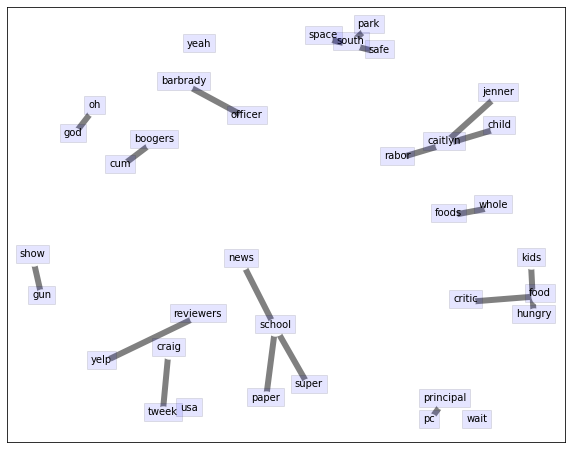

In [40]:
#3
visualize_bigrams(out)

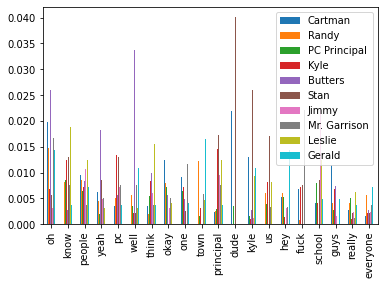

In [41]:
#4      
tf_idf = calculate_tf_idf(out, 20, get_most_important_chars(out, 10))
visualize_tf_idf(tf_idf)

In [42]:
#5
model = LDA(out)
model.run_model()

[(0,
  '0.026*"craig" + 0.020*"gay" + 0.019*"tweek" + 0.015*"rule" + 0.011*"jenner" '
  '+ 0.010*"caitlyn" + 0.008*"asian" + 0.008*"yaoi" + 0.008*"cupid" + '
  '0.007*"hero"'),
 (1,
  '0.013*"jimmi" + 0.013*"paper" + 0.013*"disabl" + 0.010*"stori" + '
  '0.010*"read" + 0.009*"newspap" + 0.007*"super" + 0.006*"jim" + '
  '0.006*"crush" + 0.005*"click"'),
 (2,
  '0.016*"critic" + 0.013*"canadian" + 0.012*"yelp" + 0.012*"review" + '
  '0.011*"david" + 0.009*"cum" + 0.009*"booger" + 0.009*"restaur" + '
  '0.009*"star" + 0.009*"immigr"'),
 (3,
  '0.001*"jimmi" + 0.001*"david" + 0.001*"safe" + 0.001*"special" + '
  '0.001*"yelp" + 0.001*"space" + 0.001*"review" + 0.001*"critic" + '
  '0.001*"sodosopa" + 0.001*"booger"'),
 (4,
  '0.033*"gun" + 0.011*"classi" + 0.011*"mom" + 0.010*"human" + 0.010*"stan" + '
  '0.007*"enemi" + 0.007*"bed" + 0.007*"kill" + 0.006*"jimmi" + 0.006*"fire"'),
 (5,
  '0.021*"safe" + 0.021*"space" + 0.019*"comment" + 0.016*"hungri" + '
  '0.015*"dollar" + 0.011*"shame"

In [119]:
model.vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.136077 -0.159010       1        1  21.457048
8      0.124748  0.125613       2        1  16.159939
4     -0.077971 -0.062607       3        1  14.620617
10     0.094471 -0.020494       4        1   8.927939
1      0.055892  0.082156       5        1   8.290176
3     -0.074723  0.147734       6        1   8.092242
7     -0.153144 -0.080546       7        1   7.784531
5     -0.084379  0.021579       8        1   7.355563
6      0.020032 -0.052869       9        1   7.300596
9     -0.011300  0.000881      10        1   0.002867
11    -0.009898 -0.001708      11        1   0.002853
0     -0.010147 -0.000248      12        1   0.002821
12    -0.009660 -0.000483      13        1   0.002800, topic_info=     Category       Freq      Term      Total  loglift  logprob
1090  Default  51.000000       gay  51.000000  30.0000  30.0000
3027  Default  30.000000   triangl  30.000000  29.0000  29.0000
893   Default  27.000000       pig  27.000000  28.0000  28.0000
1820  Default  40.000000  christma  40.000000  27.0000  27.0000
1356  Default  24.000000     eleph  24.000000  26.0000  26.0000
...       ...        ...       ...        ...      ...      ...
1592  Topic13   0.000083     death   7.233517  -0.8964  -8.0332
266   Topic13   0.000084     shoot  14.928723  -1.6067  -8.0189
496   Topic13   0.000086      jesu  44.685902  -2.6829  -7.9987
938   Topic13   0.000084   stanley  21.877037  -1.9831  -8.0132
472   Topic13   0.000084       gun  15.979117  -1.6740  -8.0182

[793 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
992       2  0.830547  aaaaahh
993       1  0.078630     aaah
993       2  0.157261     aaah
993       4  0.078630     aaah
993       6  0.157261     aaah
...     ...       ...      ...
1768      1  0.935063     york
2011      7  0.947264   yother
3056      6  0.924080  zinthar
2014      6  0.072587    zombi
2014      7  0.943631    zombi

[951 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 5, 11, 2, 4, 8, 6, 7, 10, 12, 1, 13])

[[1, -0.08327550312283137],
 [2, -0.09642074506939372],
 [3, 0.04941176470588235],
 [4, -0.019372077488309953],
 [5, 0.017208413001912046],
 [6, -0.000864304235090752],
 [7, -0.0890302066772655],
 [8, -0.048334421946440234],
 [9, -0.11211924821775761],
 [10, -0.0775034293552812]]

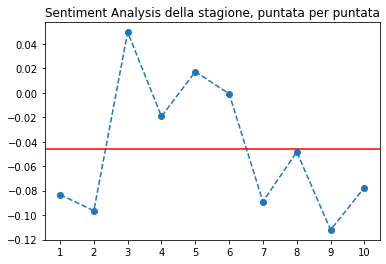

In [72]:
#6 
Make_Sentiment(out).run()


'''
in pre processing abbiamo sostituito "&" con "and"
                                     "  " con " "




output:
    
    1) grafica di chi ha più battute
            get_descr_stat(out)
            
    2) bow in base a personaggi e frequenze
            get_bag_of_words_by_char(out, 10, get_most_important_chars(out, 9))
            
    3) visualizzazione bigrammi
            visualize_bigrams(out)
    
    4) tf-idf
            tf_idf = calculate_tf_idf(out, 20, get_most_important_chars(out, 10))
            visualize_tf_idf(tf_idf)
            
    5) LDA
            model = LDA(out)
            model.run_model()
            
    6) sentiment analysis
            Make_Sentiment(out).run()
            
    7) word cloud
            

'''
